In [1]:
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import mlflow
import mlflow.sklearn

In [2]:
TARGET_COL = "cost"

NUMERIC_COLS = [
    "distance", "dropoff_latitude", "dropoff_longitude", "passengers", "pickup_latitude",
    "pickup_longitude", "pickup_weekday", "pickup_month", "pickup_monthday", "pickup_hour",
    "pickup_minute", "pickup_second", "dropoff_weekday", "dropoff_month", "dropoff_monthday",
    "dropoff_hour", "dropoff_minute", "dropoff_second"
]

CAT_NOM_COLS = [
    "store_forward", "vendor"
]

CAT_ORD_COLS = [
]


In [3]:
# Define Arguments for this step

class MyArgs:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = MyArgs(
                model_name = "taxi-model",
                model_input = "/tmp/train",
                test_data = "/tmp/prep/test",
                )


In [4]:

def main(args):
    '''Read trained model and test dataset, evaluate model and save result'''

    # Load the test data
    test_data = pd.read_parquet(Path(args.test_data)/"test.parquet")

    # Split the data into inputs and outputs
    y_test = test_data[TARGET_COL]
    X_test = test_data[NUMERIC_COLS + CAT_NOM_COLS + CAT_ORD_COLS]

    # Load the model from input port
    model =  mlflow.sklearn.load_model(args.model_input) 

    # ---------------- Model Evaluation ---------------- #
    yhat_test, score = model_evaluation(X_test, y_test, model)

def model_evaluation(X_test, y_test, model):

    # Get predictions to y_test (y_test)
    yhat_test = model.predict(X_test)

    # Evaluate Model performance with the test set
    r2 = r2_score(y_test, yhat_test)
    mse = mean_squared_error(y_test, yhat_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, yhat_test)

    mlflow.log_metric("test r2", r2)
    mlflow.log_metric("test mse", mse)
    mlflow.log_metric("test rmse", rmse)
    mlflow.log_metric("test mae", mae)

    # Visualize results
    plt.scatter(y_test, yhat_test,  color='black')
    plt.plot(y_test, y_test, color='blue', linewidth=3)
    plt.xlabel("Real value")
    plt.ylabel("Predicted value")
    plt.title("Comparing Model Predictions to Real values - Test Data")
    plt.savefig("predictions.png")
    mlflow.log_artifact("predictions.png")

    return yhat_test, r2

Model name: taxi-model
Model path: /tmp/train
Test data path: /tmp/prep/test


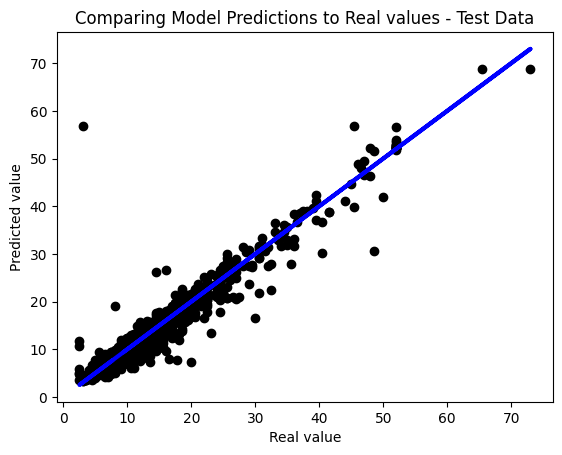

In [5]:
mlflow.start_run()

lines = [
    f"Model name: {args.model_name}",
    f"Model path: {args.model_input}",
    f"Test data path: {args.test_data}",
]

for line in lines:
    print(line)

main(args)

mlflow.end_run()